<a href="https://colab.research.google.com/github/polrgn/biomedical_clustering_topic_modeling/blob/main/4_multiview_rep_learning_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load libraries and data

In [ ]:
import numpy as np 
import pandas as pd
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
import scipy.sparse
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import scale
from time import time
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score, pairwise
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
from keras.models import Model, load_model
from tensorflow.python.keras.layers import  Embedding
from sklearn.neighbors import kneighbors_graph

Mount Google drive

In [ ]:
# Mounting Google drive where we save our data and embeddings
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Read the data

In [ ]:
lda_view = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/lda_abstract_df.csv',index_col=0).drop(['cord_uid','abstract','word_count'],axis=1)
ae_view = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/ae_encoded_abstract_df_64.csv',index_col=0).drop(['cord_uid','abstract','word_count'],axis=1)
tfidf_view = scipy.sparse.load_npz('drive/MyDrive/Projet MedML/Outputs/tfidf_abstract.npz')
tfidf_view_array = np.squeeze(np.asarray(tfidf_view.todense()))
abstract_df = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/abstract_df_clean_stopwords_lang_abstrlen.csv',index_col=0)[0:10000]
list_stop_words = np.load("drive/MyDrive/Projet MedML/Data/list_stopwords.npz")
list_stop_words = list(list_stop_words['arr_0'])

Check dimensions

In [ ]:
print(np.shape(lda_view),np.shape(ae_view),np.shape(tfidf_view))

(10000, 10) (10000, 64) (10000, 5000)


We load package multiview and edit mvmds function so it ouputs both common eigenvectors and eigenvalues.

In [ ]:
!pip install multiview

     |████████████████████████████████| 2.1MB 33.7MB/s 
  Created wheel for multiview: filename=multiview-1.0-cp37-none-any.whl size=25345 sha256=931db05284a24fc2bb1bebb408e7bb1b48fad1ff58efd743c7220fa203f8f841
  Stored in directory: /root/.cache/pip/wheels/04/d1/ca/78db5c5801ce4df83d63857b2354ca2f55050fd7bf09a2e07d
Successfully built multiview


In [ ]:
"""
Multiview MDS (multidimensional scaling) provides a representation of the
pattern of proximities among a set of matrices. Likewise, these matrices are
composed of different attributes, which have a pattern of proximities as well.
Coding of two principal functions found in mvmds file. The first function,
preprocess mvmds, preprocess data for multiview MDs algorithm The second,
md_mds, computes the MDS algorithm itself for a set of matrices.
"""


import numpy as np
import multiview.cpcmv as cpcmv
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.base import BaseEstimator
from sklearn.utils import check_array
import warnings


def preprocess_mvmds(values):
    """ Preprocess of a distance matrix for mvMDS (square + double center).
    Parameters
    ----------
    values: ndarray
        The distance matrix to be preprocessed.
    Returns
    -------
    p_matrix: nparray
        The preprocessed matrix (same dimensions)
    """

    values = check_array(values)

    p_matrix = values ** 2
    row_means = np.mean(p_matrix, axis=1)
    col_means = np.mean(p_matrix, axis=0)
    all_means = np.mean(p_matrix)

    p_matrix += all_means
    p_matrix.T[:, ] -= row_means[:]
    p_matrix -= col_means
    return p_matrix


def mvmds(x, is_distance, k=2):
    """
    Multiview MDS on a list of matrices.
    Multiview multidimensional scaling (mvmds) receives two or more
    feature matrices or distance matrices, according to is_distance parameters
    and produces a low-dimensional representation of the samples according to
    the combined information in all the input data.
    In the case of plain data matrices, euclidean distance will be used to
    generate distance matrices for that data view.
    Mv_MDS preprocess input matrix wih square and double center.
    Notes
    -----
    All input views must have the same number of samples (rows).
    Parameters
    ----------
    x : list
        A list of data matrices. Matrices can be raw data or distancematrices.
        In the case of plain data matrices, euclidean distance will be used to
        generate a distance matrix for that data view.
    is_distance : list
        Each boolean value indicates wheter the matrix in x with the same
        index is a distance matrix or not.
    k : int, default: 2
        Number of desired dimensions of the low-dimensional projection.
    Returns
    -------
    common : ndarray
        A n x k matrix with the k-dimensional projection, where n is the
        number of samples in the dataset.
    Raises
    ------
        ValueError: Matrices are not square matrices, k value is negative or
        data samples and is_distance parameters do not have the same length.
    """

    # Number of rows/observations
    num_obs = x[0].shape[0]
    my_mat = np.zeros((len(x), num_obs, num_obs))
    for i in np.arange(len(x)):
        if not is_distance[i]:
            # It is not a distance matrix
            my_view = euclidean_distances(x[i])
        else:
            my_view = x[i]
        my_views2 = preprocess_mvmds(my_view)
        my_mat[i] = -my_views2 / 2
    cpc = cpcmv.MVCPC(k=k)
    common = cpc.fit_transform(my_mat)
    return common 


class MVMDS(BaseEstimator):
    """
    It  receives two or more feature matrices or distance matrices, according
    to is_distance parameters and produces a low-dimensional representation
    of the samples according to the combined information in all the input data.
    In the case of plain data matrices, euclidean distance will be used to
    generate distance matrices for that data view.
    Mv_MDS preprocess input matrix wih square and double center.
    Notes
    -----
    All input views must have the same number of samples (rows).
    Parameters
    ----------
    k : int, default: 2
        Number of desired dimensions of the low-dimensional projection.
    Attributes
    ----------
    components_ : ndarray
        Principal components of the dataset input.
    References
    ----------
        Kruskal, J B. 1964. “Multidimensional scaling by optimizing goodness
        of fit to a nonmetric hypothesis.” *Psychometrika* 29 (1): 1–27.
        doi:10.1007/BF02289565.
        Trendafilov, Nickolay T. 2010. “Stepwise estimation of common principal
        components.” *Computational Statistics and Data Analysis* 54 (12):
        3446–57. doi:10.1016/j.csda.2010.03.010.
    """

    def __init__(self, k=2):
        self.k = k

    def fit(self, x, is_distance):
        """
        Computes euclidean distances of X according to ``is_distance``,
        preprocess these data and fit them.
        Parameters
        ----------
        x : list
            A list of data matrices. Matrices can be raw data or distance
            matrices. In the case of plain data matrices, euclidean distance
            will be used to generate a distance matrix for that data view.
        is_distance : list
            Each boolean value indicates wheter the matrix in x with the same
            index is a distance matrix or not.
        """

        self.fit_transform(x, is_distance)
        return self

    def fit_transform(self, x, is_distance):
        """
        Computes euclidean distances of X according to ``is_distance``,
        preprocess these data, fit and return them.
        Parameters
        ----------
        x : list
            A list of data matrices. Matrices can be raw data or distance
            matrices. In the case of plain data matrices, euclidean distance
            will be used to generate a distance matrix for that data view.
        is_distance : list
            Each boolean value indicates wheter the matrix in x with the same
            index is a distance matrix or not.
        Returns
        -------
        common : ndarray
            A n x k matrix with the k-dimensional projection, where n is the
            number of samples in the dataset.
        Raises
        ------
            ValueError: Matrices are not square matrices, k value is negative
            or data samples and is_distance parameters do not have the same
            length.
        Examples
        --------
        >>> import numpy as np
        >>> m = np.array([[1, 4], [2, 5], [3, 6]])
        >>> r = np.array([[2, 4], [1, 5], [8, 6]])
        >>> matrices = [m, r]
        >>> is_distance = [False, False]
        >>> mv_mds = MVMDS(k=2)
        >>> mv_mds.fit_transform(matrices, is_distance)
        array([[-0.55030705 -0.60318224]
               [-0.24721761  0.77817101]
               [ 0.79752467 -0.17498877]])
        """

        if len(x) != len(is_distance):
            raise ValueError("Data samples and is_distance lengths does not "
                             "match. Data sample length: %d, is_distance "
                             "length: %d" % (len(x), len(is_distance)))

        if self.k > x[0].shape[0]:
            self.k = x[0].shape[0]
            warnings.warn("k is greater than matrix dimension. k=%d is "
                          "computed instead." % x[0].shape[0])
        elif self.k < 0:
            raise ValueError("k value must be between 0 and number of samples"
                             " of data matrix.")
        for i in np.arange(len(x) - 1):
            for j in np.arange(i + 1, len(x)):
                if x[i].shape[0] != x[j].shape[0]:
                    raise ValueError("Input data matrices have no same number "
                                     "of samples (rows).")
        common = mvmds(x, is_distance, self.k)
        self.components_ = common
        return self.components_


# Multiview MDS on documents + LDA topics

We add to each view, the representation of the 10 LDA topics

In [ ]:
# Load saved topics
topics_df = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/topics_lda_df.csv',index_col=0)
topics = topics_df['topic']

# Add to LDA view
with open(r"drive/MyDrive/Projet MedML/Outputs/lda_countvectorizer.pickle", "rb") as input_file:
  lda_countvectorizer = pickle.load(input_file)
lda_model = joblib.load('drive/MyDrive/Projet MedML/Outputs/lda_model.jl')
array_topic_lda = lda_model.transform(lda_countvectorizer.transform(topics))
lda_view_withtopics = np.append(lda_view,array_topic_lda,axis=0)

# Add to tfidf view
with open(r"drive/MyDrive/Projet MedML/Outputs/tfidf_vectorizer.pickle", "rb") as input_file:
  tfidfvectorizer = pickle.load(input_file)
array_topic_tfidf = tfidfvectorizer.transform(topics)
tfidf_view_withtopics = np.append(tfidf_view.todense(),array_topic_tfidf.todense(),axis=0)


In [ ]:
# Add to autoencoder view
with open(r"drive/MyDrive/Projet MedML/Outputs/autoencoder_vectorizer.pickle", "rb") as input_file:
  t = pickle.load(input_file)
tokenized_topics = t.texts_to_sequences(topics)
padded_topics = pad_sequences(tokenized_topics, maxlen=max(abstract_df.word_count))

embedding_matrix = np.loadtxt('drive/MyDrive/Projet MedML/Outputs/embedding_matrix.csv',delimiter=',')
maxlen = max(abstract_df.word_count)
EMBEDDING_DIM = np.shape(embedding_matrix)[1]
embedding_layer = Embedding(len(t.word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length= maxlen,
                            trainable=False)
embedded_topics= embedding_layer(padded_topics)

encoder = load_model('drive/MyDrive/Projet MedML/Outputs/encoder_64.h5') 

array_topic_ae = encoder.predict(embedded_topics)
ae_view_withtopics = np.append(ae_view,array_topic_ae,axis=0)

Check dimensions and normalize.

In [ ]:
print(np.shape(lda_view_withtopics))
print(np.shape(tfidf_view_withtopics))
print(np.shape(ae_view_withtopics))

nm = Normalizer(copy=False)

lda_view_withtopics_nmed = nm.fit_transform(lda_view_withtopics)
ae_view_withtopics_nmed = nm.fit_transform(ae_view_withtopics)
tfidf_view_withtopics_nmed = nm.fit_transform(tfidf_view_withtopics)

(10010, 10)
(10010, 5000)
(10010, 64)


We extract the first 20 common eigenvectors and the eigenvalues

In [ ]:
mvmds_own = MVMDS(k=20)
is_distance = [False] * 3
eigen,projection = mvmds_own.fit_transform([lda_view_withtopics_nmed,ae_view_withtopics_nmed,tfidf_view_withtopics_nmed],
                                 is_distance)

In [ ]:
eigenvalues_df = pd.DataFrame({'lda':eigen[:,0],'ae':eigen[:,1],'tfidf':eigen[:,2]})
eigenvalues_df['order'] = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
eigenvalues_df

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))

sns.lineplot(
    x="order", y="lda",
    data=eigenvalues_df,
    marker="o",
    ax = axs[0,0])
axs[0,0].set(ylabel = 'Eigenvalue LDA', xlabel = 'Order')

sns.lineplot(
    x="order", y="ae",
    data=eigenvalues_df,
    marker="o",
    legend="full",
    ax = axs[0,1])
axs[0,1].set(ylabel = 'Eigenvalue LSTM-AE', xlabel = 'Order')


sns.lineplot(
    x="order", y="tfidf",
    data=eigenvalues_df,
    marker="o",
    legend="full",
    ax = axs[1,0])
axs[1,0].set(ylabel = 'Eigenvalue TF-IDF', xlabel = 'Order')
axs[-1, -1].axis('off')

plt.show()
fig.savefig("drive/MyDrive/Projet MedML/Images/eigenvalues_ncomponents_mvmds.png")

We compute cluster performance metrics for different numbers of components in our multiview MDS   

In [ ]:
range_dim = [3,5,7,10,20]
range_n_clusters = [5,10,15,20,30]
results = pd.DataFrame()
for d in range_dim:
  mvmds_own = MVMDS(k=d)
  is_distance = [False] * 3
  projection = mvmds_own.fit_transform([lda_view_withtopics_nmed,ae_view_withtopics_nmed,tfidf_view_withtopics_nmed],
                                 is_distance)
  print('Dimension MVMDS', d, 'dimension projection',np.shape(projection))
  temp = sv_clustering(projection,range_n_clusters)
  temp['dimension'] = [d,d,d,d,d]

  results = pd.concat([results,temp], axis = 0)

Dimension MVMDS 3 dimension projection (10010, 3)
   n_cluster  silhouette     CH_score  DB_score
0          5    0.349940  6333.582360  1.035118
1         10    0.304442  5761.035383  0.995502
2         15    0.275826  5259.119551  1.015754
3         20    0.254307  4659.465599  1.092356
4         30    0.246049  4163.297352  1.062760
Dimension MVMDS 5 dimension projection (10010, 5)
   n_cluster  silhouette     CH_score  DB_score
0          5    0.294186  2963.248989  1.164303
1         10    0.250812  2657.335570  1.249362
2         15    0.220541  2230.763368  1.324973
3         20    0.196643  1902.153875  1.439933
4         30    0.182949  1617.477321  1.380911
Dimension MVMDS 7 dimension projection (10010, 7)
   n_cluster  silhouette     CH_score  DB_score
0          5    0.206487  1609.462936  1.681298
1         10    0.238461  1758.664186  1.367373
2         15    0.206023  1471.712848  1.455952
3         20    0.170214  1280.834191  1.541005
4         30    0.161589  1060.225

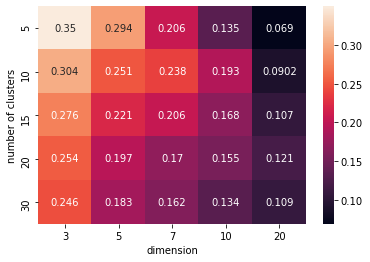

In [ ]:
metric_score = results.pivot("n_cluster", "dimension", "silhouette")
ax = sns.heatmap(metric_score,annot=True,fmt='.3g')
ax.set(ylabel='number of clusters')
ax.get_figure().savefig("drive/MyDrive/Projet MedML/Images/mvmds_optimdim_silhouette.png")

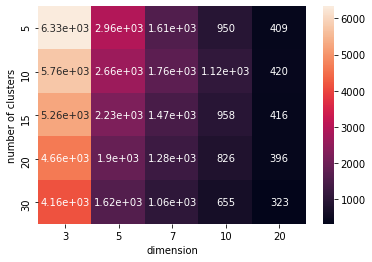

In [ ]:
metric_score = results.pivot("n_cluster", "dimension", "CH_score")
ax = sns.heatmap(metric_score,annot=True,fmt='.3g')
ax.set(ylabel='number of clusters')
ax.get_figure().savefig("drive/MyDrive/Projet MedML/Images/mvmds_optimdim_chscore.png")

In [ ]:
metric_score = results.pivot("n_cluster", "dimension", "DB_score")
ax = sns.heatmap(metric_score,annot=True,fmt='.3g')
ax.set(ylabel='number of clusters')
ax.get_figure().savefig("drive/MyDrive/Projet MedML/Images/mvmds_optimdim_dbscore.png")

We build the multiview multidimensional scaling with 10 components.

In [ ]:
from multiview.mvmds import MVMDS

t0 = time()
mvmds = MVMDS(k=10)
is_distance = [False] * 3
projection_df = mvmds.fit_transform([lda_view_withtopics_nmed,ae_view_withtopics_nmed,tfidf_view_withtopics_nmed],
                                 is_distance)
print("done in %0.3fs." % (time() - t0))

done in 334.779s.


# Clustering

## Mini batch k means

We run mini batch k-means for 10 components

In [ ]:
km = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=10,
                     init_size=1000, batch_size=1000)

km_centers = km.cluster_centers_
np.save("drive/MyDrive/Projet MedML/Outputs/km_mv_clusters_centers",km_centers)

cluster_labels = km.fit_predict(projection_df)
projection_df = pd.DataFrame(projection_df)
projection_df['cluster'] = cluster_labels

l = list(abstract_df.index)
labels = ["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5",
          "Topic 6","Topic 7","Topic 8","Topic 9","Topic 10"]
for x in labels:
    l.append(x)
projection_df.index = l
projection_df.rename(columns={0:"mds-10d-one",1:"mds-10d-two",2:"mds-10d-three"}, inplace=True)
projection_df.to_csv('drive/MyDrive/Projet MedML/Outputs/mvmds_projection.csv')

## Plot in first 3 components

We plot the documents and topics in the multiview MDS representation.

In [ ]:
projection_df = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/mvmds_projection.csv',index_col=0)[0:10000]
labels = ["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5",
          "Topic 6","Topic 7","Topic 8","Topic 9","Topic 10"]

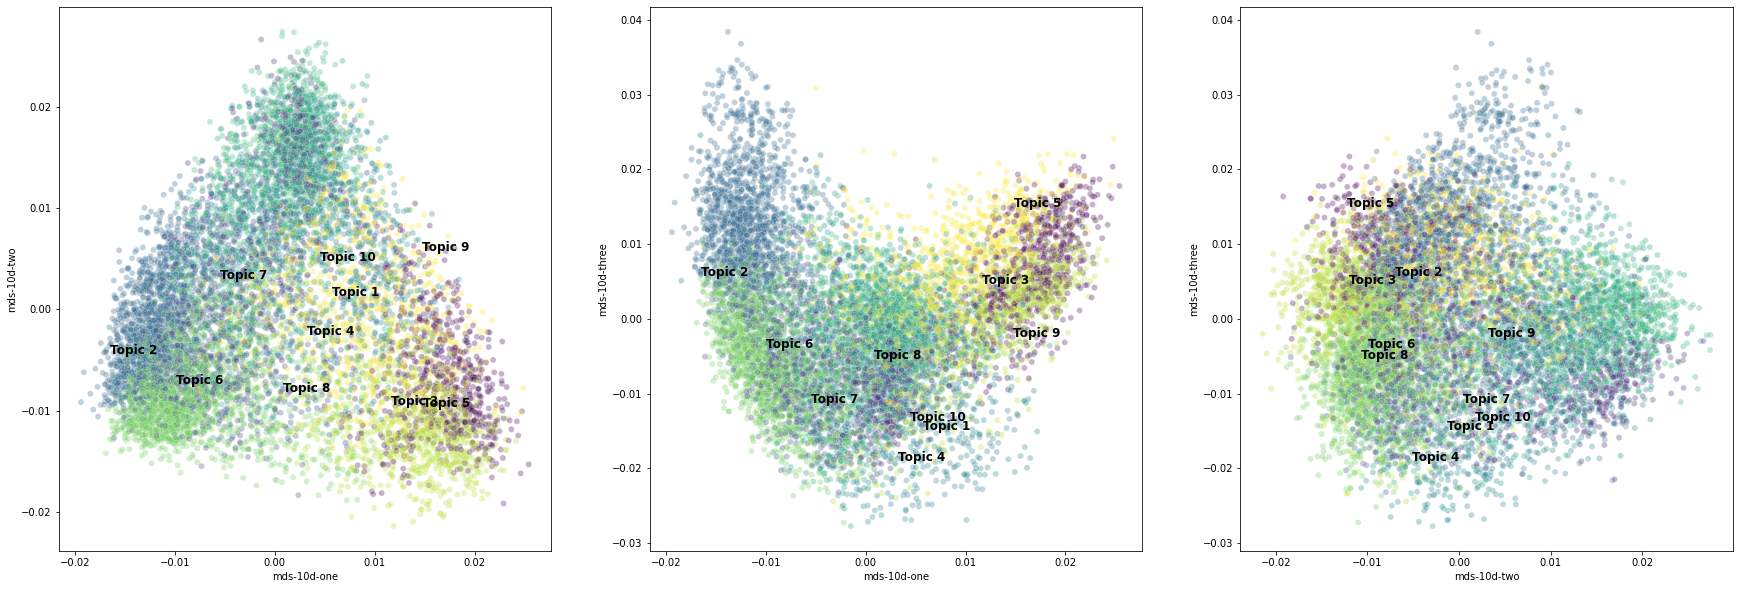

In [ ]:
fig, axs = plt.subplots(1, 3,figsize=(30,10))

sns.scatterplot(
    x="mds-10d-one", y="mds-10d-two",
    palette=sns.color_palette("hls", 10),
    data=projection_df,
    legend="full",
    c=projection_df['cluster'],
    alpha=0.3,
    ax = axs[0])

sns.scatterplot(
    x="mds-10d-one", y="mds-10d-three",
    palette=sns.color_palette("hls", 10),
    data=projection_df,
    legend="full",
    c=projection_df['cluster'],
    alpha=0.3,
    ax = axs[1])


sns.scatterplot(
    x="mds-10d-two", y="mds-10d-three",
    palette=sns.color_palette("hls", 10),
    data=projection_df,
    legend="full",
    c=projection_df['cluster'],
    alpha=0.3,
    ax = axs[2])

j=0
for i in range(projection_df.shape[0]-10,projection_df.shape[0]):
     axs[0].text(projection_df["mds-10d-one"].iloc[i], projection_df["mds-10d-two"].iloc[i], 
     labels[j], horizontalalignment='center', 
     size='large', color='black', weight='semibold')

     axs[1].text(projection_df["mds-10d-one"].iloc[i], projection_df["mds-10d-three"].iloc[i], 
     labels[j], horizontalalignment='center', 
     size='large', color='black', weight='semibold')  

     axs[2].text(projection_df["mds-10d-two"].iloc[i], projection_df["mds-10d-three"].iloc[i], 
     labels[j], horizontalalignment='center', 
     size='large', color='black', weight='semibold')

     j+=1


plt.show()
fig.savefig("drive/MyDrive/Projet MedML/Images/mvmds_3views_10comps.png")

In [ ]:
topic_mvmds = projection_df.iloc[(projection_df.shape[0]-10):projection_df.shape[0],].drop('cluster',axis=1)
topic_mvmds.to_csv("drive/MyDrive/Projet MedML/Outputs/mvmds_topics.csv")
pw_dist_abstracts = pd.DataFrame(pairwise.euclidean_distances(projection_df[0:10000]))
pw_dist_abstracts.index = abstract_df.cord_uid
pw_dist_abstracts.columns = abstract_df.cord_uid
pw_dist_abstracts.to_csv("drive/MyDrive/Projet MedML/Outputs/pw_dist_abstracts.csv")

## Consistence between multiview clustering and single view clusterings

We compute cohesion metrics between multiview clustering and single view clusterings.

In [ ]:
abstract_df = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/abstract_df_clean_stopwords_lang_abstrlen.csv',index_col=0)[0:10000]
projection_df = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/mvmds_projection.csv',index_col=0)[0:10000]
projection_df.index = projection_df.index.astype('int64')

abstract_df_clusterized = abstract_df
abstract_df_clusterized['cluster_mvmds'] = projection_df['cluster'].iloc[0:10000]

nm = Normalizer(copy=False)

lda_view_nmed = nm.fit_transform(lda_view)
ae_view_nmed = nm.fit_transform(ae_view)
tfidf_view_nmed = nm.fit_transform(tfidf_view_array)

X = ae_view_nmed
km = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=10,
                     init_size=1000, batch_size=1000)
cluster_labels = km.fit_predict(X)
abstract_df_clusterized ['cluster_ae'] = cluster_labels

X = tfidf_view_nmed
km = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=10,
                     init_size=1000, batch_size=1000)
cluster_labels = km.fit_predict(X)
abstract_df_clusterized ['cluster_tfidf'] = cluster_labels

X = lda_view_nmed
km = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=10,
                     init_size=1000, batch_size=1000)
cluster_labels = km.fit_predict(X)
abstract_df_clusterized ['cluster_lda'] = cluster_labels

rand_score =[]
rand_score.append(adjusted_rand_score(abstract_df_clusterized['cluster_lda'],abstract_df_clusterized ['cluster_mvmds']))
rand_score.append(adjusted_rand_score(abstract_df_clusterized['cluster_mvmds'],abstract_df_clusterized ['cluster_tfidf']))
rand_score.append(adjusted_rand_score(abstract_df_clusterized['cluster_mvmds'],abstract_df_clusterized ['cluster_ae']))

nmi_score =[]
nmi_score.append(adjusted_mutual_info_score(abstract_df_clusterized['cluster_lda'],abstract_df_clusterized ['cluster_mvmds']))
nmi_score.append(adjusted_mutual_info_score(abstract_df_clusterized['cluster_mvmds'],abstract_df_clusterized ['cluster_tfidf']))
nmi_score.append(adjusted_mutual_info_score(abstract_df_clusterized['cluster_mvmds'],abstract_df_clusterized ['cluster_ae']))

fm_score =[]
fm_score.append(fowlkes_mallows_score(abstract_df_clusterized['cluster_lda'],abstract_df_clusterized ['cluster_mvmds']))
fm_score.append(fowlkes_mallows_score(abstract_df_clusterized['cluster_mvmds'],abstract_df_clusterized ['cluster_tfidf']))
fm_score.append(fowlkes_mallows_score(abstract_df_clusterized['cluster_mvmds'],abstract_df_clusterized ['cluster_ae']))

clust_compare = pd.DataFrame({'pairwise comparison': ['lda-mvmds','mvmds-tfidf','mvmds-ae'],
                              'Adj. Rand': rand_score,
                              'Adj. NMI': nmi_score,
                              'Fowlkes Mallows': fm_score})

print(clust_compare)
clust_compare.to_csv('drive/MyDrive/Projet MedML/Outputs/compare_mvmds_singleview_clusterings.csv')

  pairwise comparison  Adj. Rand  Adj. NMI  Fowlkes Mallows
0           lda-mvmds   0.523661  0.575510         0.583624
1         mvmds-tfidf   0.285421  0.416926         0.369998
2            mvmds-ae   0.306490  0.420846         0.385262


In [ ]:
rand_score =[]
rand_score.append(adjusted_rand_score(abstract_df_clusterized['cluster_lda'],abstract_df_clusterized ['cluster_ae']))
rand_score.append(adjusted_rand_score(abstract_df_clusterized['cluster_lda'],abstract_df_clusterized ['cluster_tfidf']))
rand_score.append(adjusted_rand_score(abstract_df_clusterized['cluster_tfidf'],abstract_df_clusterized ['cluster_ae']))

nmi_score =[]
nmi_score.append(adjusted_mutual_info_score(abstract_df_clusterized['cluster_lda'],abstract_df_clusterized ['cluster_ae']))
nmi_score.append(adjusted_mutual_info_score(abstract_df_clusterized['cluster_lda'],abstract_df_clusterized ['cluster_tfidf']))
nmi_score.append(adjusted_mutual_info_score(abstract_df_clusterized['cluster_tfidf'],abstract_df_clusterized ['cluster_ae']))

fm_score =[]
fm_score.append(fowlkes_mallows_score(abstract_df_clusterized['cluster_lda'],abstract_df_clusterized ['cluster_ae']))
fm_score.append(fowlkes_mallows_score(abstract_df_clusterized['cluster_lda'],abstract_df_clusterized ['cluster_tfidf']))
fm_score.append(fowlkes_mallows_score(abstract_df_clusterized['cluster_tfidf'],abstract_df_clusterized ['cluster_ae']))

clust_compare = pd.DataFrame({'pairwise comparison': ['lda-ae','lda-tfidf','tfidf-ae'],
                              'Adj. Rand': rand_score,
                              'Adj. NMI': nmi_score,
                              'Fowlkes Mallows': fm_score})

print(clust_compare)
clust_compare.to_csv('drive/MyDrive/Projet MedML/Outputs/compare_singleview_clusterings_10clusters.csv')

  pairwise comparison  Adj. Rand  Adj. NMI  Fowlkes Mallows
0              lda-ae   0.266140  0.396109         0.357696
1           lda-tfidf   0.243446  0.374684         0.340810
2            tfidf-ae   0.292669  0.414626         0.377673


## Number of abstracts per cluster

We count the number of abstracts in each cluster.

In [ ]:
counts_cluster = projection_df['cluster'].value_counts()
print(counts_cluster)
np.sum(counts_cluster)
counts_cluster.to_csv('drive/MyDrive/Projet MedML/Outputs/number_doc_per_mvmdscluster.csv')

7    1725
3    1451
4    1064
6    1052
2     993
8     899
9     878
0     722
5     687
1     529
Name: cluster, dtype: int64


### Top keywords by cluster

We extract keywords by MVMDS clusters. We filter out terms that are not present in MeSH terms and terms that belong to LDA topics.

In [ ]:
with open(r"drive/MyDrive/Projet MedML/Outputs/tfidf_vectorizer.pickle", "rb") as input_file:
    tfidfvectorizer = pickle.load(input_file)
voc_df = pd.DataFrame(tfidfvectorizer.vocabulary_.items())
voc_df.columns=['token','index']
voc_df = voc_df.sort_values(by='index')
tfidf_view_df = pd.DataFrame(tfidf_view_array)
tfidf_view_df.columns = voc_df['token']

In [ ]:
mesh_voc = pd.read_table('drive/MyDrive/Projet MedML/Data/mesh_terms.txt')

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
mesh_tokenizer = vectorizer.fit(mesh_voc['mesh_name'])

mesh_term_df = pd.DataFrame(mesh_tokenizer.vocabulary_.items())

ldatopics_tokenizer = vectorizer.fit(topics_df['topic'])

ldatopic_term_df = pd.DataFrame(ldatopics_tokenizer.vocabulary_.items())


def get_topmesh_bycluster2(df,cluster_var,n_clust,n_topword):
    topwords_glob = pd.DataFrame()
    topwords_glob_dense = np.zeros(shape=(n_clust,2))
    cluster_vec = []
    topwords_vec = []
    with open(r"drive/MyDrive/Projet MedML/Outputs/tfidf_vectorizer.pickle", "rb") as input_file:
        tfidfvectorizer = pickle.load(input_file)
    voc_df = pd.DataFrame(tfidfvectorizer.vocabulary_.items())
    voc_df.columns=['token','index']
    voc_df = voc_df.sort_values(by='index')
    tfidf_view_df = pd.DataFrame(tfidf_view_array)
    tfidf_view_df.columns = voc_df['token']
    print(np.shape(tfidf_view_df))
    df.reset_index(drop = True, inplace = True)

    mesh_filter = tfidf_view_df.columns.isin(mesh_term_df.iloc[:,0])
    tfidf_view_df = tfidf_view_df.loc[:,mesh_filter]
    print(np.shape(tfidf_view_df))
    ldatopic_filter = ~tfidf_view_df.columns.isin(ldatopic_term_df.iloc[:,0])
    tfidf_view_df = tfidf_view_df.loc[:,ldatopic_filter]
    print(np.shape(tfidf_view_df))

    for i in range(0,n_clust):
        print('cluster',i)
        topword_clust = pd.DataFrame({'custom_index':np.sum(tfidf_view_df[df[cluster_var]==i],axis=0).sort_values(ascending=False)[0:n_topword]})
        topword_clust.reset_index(inplace=True)
        topword_clust.rename(columns={'token':'word'}, inplace=True)
        print(topword_clust[['word','custom_index']],'\n')
        topword_clust['cluster'] = str(i)
        topwords_glob = pd.concat([topwords_glob,topword_clust[['cluster','word','custom_index']]],axis=0)
        cluster_vec.append(i)
        topwords_vec.append(", ".join(topword_clust['word']))
    topwords_glob_dense = pd.DataFrame({'cluster':cluster_vec,'top_words':topwords_vec})
    return topwords_glob, topwords_glob_dense

In [ ]:
ldatopic_filter = ~tfidf_view_df.columns.isin(ldatopic_term_df.iloc[:,0])

In [ ]:
topwrds_clust_mvmds, res_dense = get_topmesh_bycluster2(abstract_df_clusterized,'cluster_mvmds',10,40)
topwrds_clust_mvmds.to_csv('drive/MyDrive/Projet MedML/Outputs/topmesh_clust_mvmds.csv')
res_dense.to_csv('drive/MyDrive/Projet MedML/Outputs/topmesh_clust_mvmds_dense.csv')

(10000, 5000)
(10000, 2339)
(10000, 2223)
cluster 0
            word  custom_index
0           mice     23.680707
1     antibodies     23.585048
2       antibody     22.529203
3       infected     16.139869
4       response     14.762799
5           anti     13.945390
6    replication     13.399803
7   neutralizing     12.669023
8        strains     12.208490
9          vitro     12.197793
10       antigen     11.918934
11      receptor     10.903456
12      vaccines     10.720244
13          type     10.707606
14   recombinant     10.554100
15         assay      9.937089
16    interferon      9.564308
17         spike      9.347132
18    production      9.310510
19        strain      9.124306
20      immunity      9.086724
21         mouse      9.063147
22   vaccination      8.859469
23    activation      8.628169
24      mediated      8.505762
25           cd8      8.277291
26     dependent      7.925793
27     expressed      7.909298
28     effective      7.893578
29      cellular  